# Basic implementation of MRI signal
This notebook implements simple versions of the most common DCE-MRI sequences. It assumes ideal conditions and later on will be adding realistic constraints. The final aim is to create a synthetic image that can be used for testing DCE-MRI analysis software. 
The code in here is based on the matlab implementation of a [DCE Digital Reference Object](https://github.com/anstepsa/dce-dro-matlab)

## Import relevant modules

In [262]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters


## Auxiliar Functions

In [263]:
def M0(k, rho):
    
    return k*rho

def relaxationTerm(acquisitionTpar, relaxationTime):
    
    return np.exp(- acquisitionTpar / relaxationTime)

def E1(TR, T1):
    
    return relaxationTerm(TR,T1)

def E2(TE, T2star):
    
    return relaxationTerm(TE,T2star)


### T1W sequences - SPGR & IR

In [270]:
def spgr_signal(s0, t1, tr, flip_angle, te, t2star):
    
    fa_radians = np.deg2rad(flip_angle)
    t2contrib = E2(TE=te, T2star=t2star)
    t1contrib = E1(TR=tr, T1=t1)
    
    num = (1 - t1contrib) 
    den = (1-np.cos(fa_radians)*t1contrib)
    scaling_factor = s0*np.sin(fa_radians)
    s = scaling_factor * t2contrib * num / den

    return s

# Define cost functions to estimate T1 with SPGR and IR
def fit_SPGR_t1(params, flip_angle, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    te = params['te'].value
    t2star = params['t2star'].value

    s = spgr_signal(s0, t1, tr, flip_angle, te, t2star)
    return (np.fabs(s) - np.fabs(values))

# Define the optimisation method
def do_spgr_fit(ydata, fa, tr, te, t2star, initial_s0=1.0, initial_t1=1000.0):
    params = Parameters()
    params.add('s0', value=initial_s0, vary=True)
    params.add('t1', value=initial_t1, vary=True, min=0.0, max=10000.0)
    params.add('tr', value=tr, vary=False)
    params.add('te', value=te, vary=False)
    params.add('t2star', value=t2star, vary=False)
    
    result = minimize(fit_SPGR_t1, params, args=(fa, ydata))

    return result    
    

In [299]:
def ir_signal(s0, t1, ti, tr, nte=0, f=1.0, k2=-1.0, C=1.0):
    
    return s0*(1-2 * f * np.exp(-(ti/t1)) - C * k2 * np.exp(-(tr-nte)/t1))


# Define fitting functions to estimate T1 with SPGR and IR
def fit_IR_t1(params, inv_times, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    nte = params['nte'].value
    c = params['c'].value
    f = params['f'].value
    f2 = params['f2'].value

    s = ir_signal(s0, t1, inv_times, tr, nte, f, f2, c)
    return (np.fabs(s) - np.fabs(values))

def do_ir_fit(ydata, tinv, tr, initial_s0=1.0, initial_t1=1000.0, phi=1.0, k2=-1.0, nte=0):
    
    params = Parameters()
    params.add('s0', value=initial_s0, vary=True)
    params.add('t1', value=initial_t1, vary=True, min=0.0, max=10000.0)
    params.add('f', value=phi, vary=True, min=0.0, max = 2.0)
    params.add('tr', value=tr, vary=False)
    params.add('nte', value=nte, vary=False)
    params.add('c', value=1.0, vary=False)
    params.add('f2', value=k2, vary=False)

    result = minimize(fit_IR_t1, params, args=(tinv, ydata))

    return result
        


### Contrast media concentrations

In [333]:
def aif_parker(time_axis):
    
    aif_parameters = {
        'A': {'mean': [0.809, 0.330],
            'std': [0.044, 0.040],
            'units': ['mmol.min']*2
            },   
        'T': {'mean': [0.17046, 0.365],
            'std': [0.00073, 0.028],
            'units': ['min']*2
            },
        'SIGMA': {'mean': [0.0563, 0.132],
            'std': [0.0011, 0.021],
            'units': ['min']*2
            },
        'ALFA': {'mean': 1.050,
            'std': 0.017,
            'units': 'mmol'
            },
        'BETA': {'mean': 0.1685,
                'std': 0.0056,
                'units': 'min-1'
                },
        's': {'mean': 38.078,
            'std': 16.78,
            'units': 'min-1'
            },
        'tau': {'mean': 0.483,
            'std': 0.015,
            'units': 'min'
            }            
    }
    
    Cp = aif_parameters['ALFA']['mean'] * np.exp(-aif_parameters['BETA']['mean'] * time_axis)
    Cp /= ( 1 + np.exp(-aif_parameters['s']['mean'] * ( time_axis - aif_parameters['tau']['mean'] )) )
    for n in range(2):
        An = aif_parameters['A']['mean'][n] / ( aif_parameters['SIGMA']['mean'][n] * np.sqrt(2 * np.pi) )
        arg_exp = - ( (time_axis - aif_parameters['T']['mean'][n])**2 ) / ( 2 * (aif_parameters['SIGMA']['mean'][n])**2 )
        Cp += ( An * np.exp(arg_exp) )
        
    return Cp
    
    
def aif_wang(time_axis, mode='LD'):
    
    if mode == 'LD':
        aif_parameters = {
            'Ascale': {'mean': 0.31,
                    'std': 0.14,
                    'cv': 0.44,
                    'units': 'mmol'
                },
            'BETA': {'mean': 0.70,
                        'std': 0.15,
                        'cv': 0.22,
                        'units': 'min-1' 
                        },
            'A': {'mean': [5.84, 0.46],
                        'std': [2.47, 0.24],
                        'cv': [0.42, 0.52],
                        'units': ['']*2 
                },
            'SIGMA': {'mean': [0.09, 0.12],
                        'std': [0.03, 0.08],
                        'cv': [0.38, 0.65],
                        'units':['min']*2 
                },
            'T': {'mean': [0.20, 0.62],
                        'std': [0.08, 0.09],
                        'cv': [0.40, 0.15],
                        'units': ['min']*2 
            },
            'R2': {'mean': 0.95,
                    'std': 0.02,
                    'cv': 0.02,
                    'units': ''
            }
        }
        
        Cp = 1.0
        for n in range(2):
            arg_exp = - ( (time_axis - aif_parameters['T']['mean'][n])**2 ) / ( 2 * (aif_parameters['SIGMA']['mean'][n])**2 )
            An = aif_parameters['A']['mean'][n]
            Cp += ( An * np.exp(arg_exp) )
        
        Cp *= aif_parameters['Ascale']['mean'] * np.log(1 + time_axis) * np.exp( -aif_parameters['BETA']['mean'] * time_axis )
    elif mode == 'SD':
        aif_parameters = {
            'A': {'mean': 0.36,
                  'std': 0.12,
                  'cv': 0.32,
                  'units': 'mmol'
                  },
            'ALFA': {'mean': 8.93,
                     'std': 5.40,
                     'cv': 0.61,
                     'units': 'min-1'
            },
            'GAMMA': {'mean': 0.61,
                     'std': 0.48,
                     'cv': 0.80,
                     'units': 'min-1'
            },
            'R2': {'mean': 0.93,
                     'std': 0.09,
                     'cv': 0.09,
                     'units': ''
            }                        
        }
        Cp1 = aif_parameters['A']['mean']
        Cp2 = ( 1 - np.exp( -aif_parameters['ALFA']['mean'] * time_axis ) )
        Cp3 = ( 1 + np.exp( -aif_parameters['GAMMA']['mean'] * time_axis ) )
        Cp = Cp1 * Cp2 * Cp3 * 0.5
        
    return Cp


In [318]:
def t1_contrast(baselineT1, relaxivity, ca_concentration_time):
    
    r10 = 1.0 / baselineT1
    r1t = relaxivity * ca_concentration_time
    
    r1ct = r10 + r1t

    return r1ct


## Spoiled Gradient Echo with Variable Flip Angle

The Spoiled Gradient Echo (SPGR) sequence is one of the most widely used MRI T1W sequences. Because it is a fast sequence that offers flexibility to favour T1 or T2 weighted, it is commonly used in dynamic studies. 
The variable flip angle (VFA) method to measure T1 relaxation, is derived from the signal equation of the SPGR sequence. There is a lot of literature available about this method, so in this notebook I'll cover the major and earlier papers providing the mathematical framework for this method.
The signal equation of the SPGR is a function of multiple parameters [Fram et al., MRI 5(3):201-8; 1987](https://pubmed.ncbi.nlm.nih.gov/3626789/):
\begin{equation} %\label{spgr}
S(\rho, \alpha, T_E, T_R, T_1, T_2^{*}) = k\rho\sin{\alpha}\frac{(1 - e^{-T_R/T_1})}{(1 - (\cos{\alpha})e^{-T_R/T_1})}e^{-T_E/T_2^{*}}
\end{equation}

where $\alpha/T_E/T_R$ are acquisition-controlled parameters: Flip Angle (degrees), Echo Time (ms) and Repetition Time (ms), respectively. $\rho/T_1/T_2$ are intrinsic parameters of the sample: spin density, longitudinal and transverse relaxation constants, respectively. $k$ is an arbitrary constant representing the effect of the $B_1$ inhomogeneity of the RF transmission coil.

Equation [1] (\ref{spgr}) can be rewritten more concisely by considering the following:

<!-- \begin{itemize} -->
<!-- \item  -->
* The arbitrary constant $k$ and the spin density $\rho$ can be grouped into a single parameter $M_0$.
<!-- \item  -->
* The effect of the intrinsic relaxation times $T_1$ and $T_2$, and the acquisition parameters $T_1$ and $T_2$ are grouped in the function forms $E_1(T_1, T_R) = \exp(-T_R/T_1) $ and $E_2(T_2^{*}, T_E) = \exp(-T_E/T_2^{*})$, respectively:
<!-- \end{itemize} -->

\begin{equation}
S(M_0, \alpha, T_E, T_R, T_1, T_2^{*}) = M_0\sin\alpha\frac{1 - E_1(T_1,T_R)}{1 - (\cos\alpha)E_1(T_1,T_R)}E_2(T_2^{*}, T_E)
\end{equation}

See below an example of signal equation for different flip angles and all other parameters constant


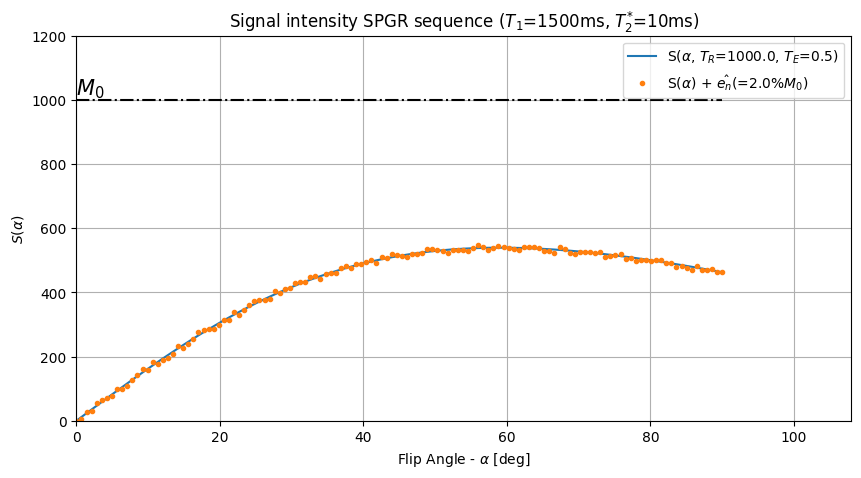

In [279]:
nt = 128
noise_factor = 0.02
[M0, T1, T2star] = [1000, 1500, 10]
flip_angles = np.linspace(0, 90, num=nt)

[TR, TE] = [1000.0, 0.5]
s_alpha = spgr_signal(M0, T1, TR, flip_angles, TE, T2star)
# Add white noise
en_alpha = noise_factor*M0*(np.random.rand(nt)-0.5)
s_alpha_noise = np.abs(s_alpha + en_alpha)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(flip_angles, s_alpha, label=r'S($\alpha$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(flip_angles, s_alpha_noise, '.', label=r'S($\alpha$) + $\hat{e_n}$'+f'(={noise_factor*100:.1f}%$M_0$)')
ax.plot(flip_angles, M0*np.ones_like(flip_angles), 'k-.')
ax.text(flip_angles[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(\alpha)$')
ax.set_xlabel(r'Flip Angle - $\alpha$ [deg]')
ax.set_title(f'Signal intensity SPGR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(flip_angles), 0.0, 1.2*M0])
plt.show()


### VFA method - Linear approximation
If we consider the $T_2^{*}$ negligible (i.e. if $T_E << T_R$), the equation \ref{spgr} becomes independent of $E_2$. By acquiring multiple flip angles $\alpha_i$, while keeping everything else constant, the equation [2] \ref{spgr} can be linearised and $T_1$ can be derived from the slope of such straight line (see details in the appendix):

\begin{equation}
\frac{S_i}{\sin\alpha_i} = E_1\frac{S_i}{\tan\alpha_i} + M_0(1-E_1)
\end{equation}

Considering the following variable changes: 
$$
y=\frac{S_i}{\sin\alpha_i} \\\
x=\frac{S_i}{\tan\alpha_i}
$$
equation [previous] represents the linear function $y=mx+n$, where:
$$
m=E_1 \\\
n=M_0(1-E_1)
$$
from which we can derive $T_1$ from the slope $m$:
$$
E_1 = e^{-T_R/T_1} \qquad /\ln()\\\
-\frac{T_R}{T_1} = \ln(E_1) \\\
T_1 = -\frac{T_R}{\ln(m)}
$$
However, in practice this approximation is very rough and imprecise, hence we acquire multiple repetitions for each angles and do a non-linear fit of equation \ref{spgr}.

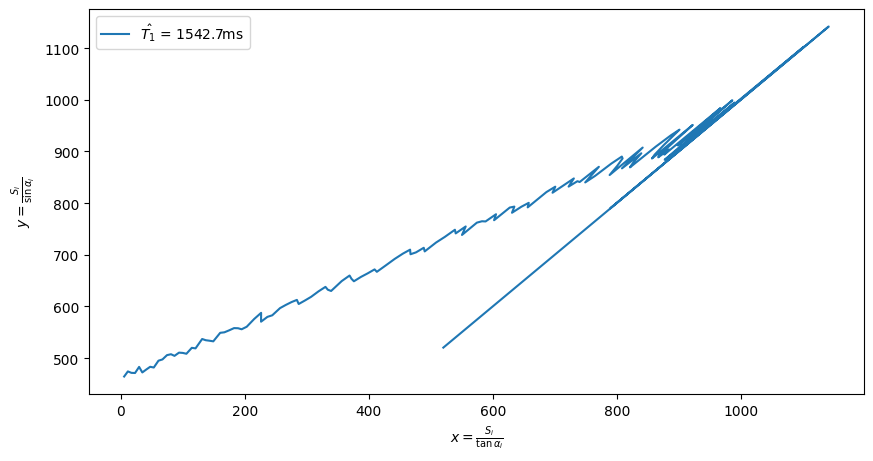

In [280]:
# Example of the linear approximation. 
# Remove the boundary conditions of the flip angles (i.e. 0 & 90 degree)
valid_fa = (flip_angles>0) & (flip_angles <90)
sin_alpha = np.sin(np.deg2rad(flip_angles))
tan_alpha = np.tan(np.deg2rad(flip_angles))
y = s_alpha_noise[valid_fa] / sin_alpha[valid_fa]
x = s_alpha_noise[valid_fa] / tan_alpha[valid_fa]
[m, n] = np.polyfit(x, y, deg=1)

T1hat = -TR / np.log(m)
M0hat = n/(1-m)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(x, y, label=r'$\hat{T_1}$ = ' + f'{T1hat:.1f}ms')
ax.set_xlabel(r'$x=\frac{S_i}{\tan\alpha_i}$')
ax.set_ylabel(r'$y=\frac{S_i}{\sin\alpha_i}$')
ax.legend(loc='best')


### Non-Linear fit
Example of a nonlinear fit using LMFIT functions

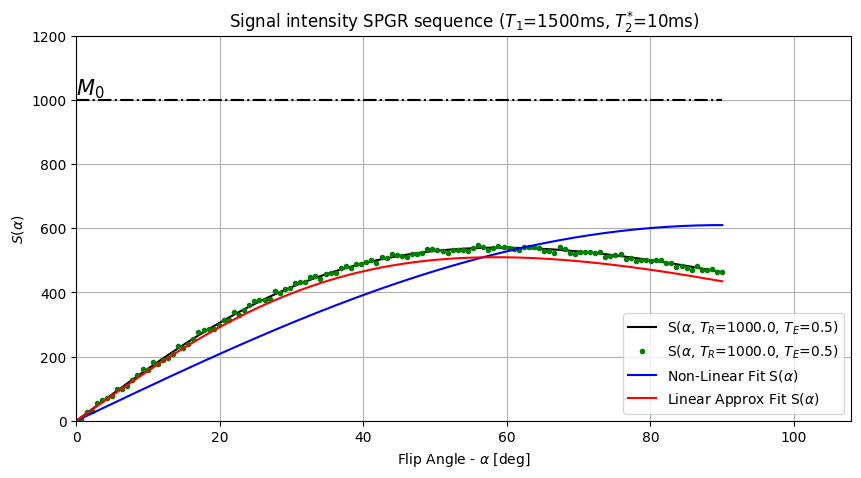

In [281]:
# Example non-linear fit
t1_opt_spgr = do_spgr_fit(s_alpha_noise, flip_angles, TR, TE, T2star)
non_lin_fit_spgr_T1 = spgr_signal(t1_opt_spgr.params['s0'].value, 
                                  t1_opt_spgr.params['t1'].value,
                                  TR, flip_angles, TE, T2star)

lin_fit_spgr_T1 = spgr_signal(M0hat, T1hat,
                              TR, flip_angles, TE, T2star)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(flip_angles, s_alpha, 'k-', label=r'S($\alpha$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(flip_angles, s_alpha_noise, 'g.', label=r'S($\alpha$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(flip_angles, non_lin_fit_spgr_T1, 'b-', label=r'Non-Linear Fit S($\alpha$)')
ax.plot(flip_angles, lin_fit_spgr_T1, 'r-', label=r'Linear Approx Fit S($\alpha$)')
ax.plot(flip_angles, M0*np.ones_like(flip_angles), 'k-.')
ax.text(flip_angles[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(\alpha)$')
ax.set_xlabel(r'Flip Angle - $\alpha$ [deg]')
ax.set_title(f'Signal intensity SPGR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(flip_angles), 0.0, 1.2*M0])
plt.show()


## Inversion Recovery Method
This is considered the gold-standard for measuring T1. It uses the fact that an inversion pre-pulse increases the contrast to the double, compared to a normal saturation (e.g. SPGR). It is more accurate than the VFA method, but takes longer to aquire and technically is more challenging to achieve a correct inversion than an homogeneous flip angle.
The length of the acquisition is dominated by the fact that in order to achieve an accurate estimation, the TR must allow for the magnetisation to return to the equilibrium state, which means $T_R >> T_1$. In practice, a rule of thumb is that the equilibrium is achieved when $T_R \geq 5T_1$.
If the FOV of interest is large (e.g. breast imaging), the IR method is not suitable as the acquisition times get too long. For smaller FOV, the Look-Locker inversion method (MOLLI) can be used.
The general equation for the longintudinal magnetisation afer a pre-pulse of $\phi$ degrees ($\phi \in [90,180]^{o}$) is given by [[P. Kingsley et al; MRI 19:279-282; 2001](https://www.sciencedirect.com/science/article/abs/pii/S0730725X01002946)]:
\begin{equation} 
S(T_I) = S_0\biggl(1 - (1 - k_1)\exp(-T_I/T_1) - k_2 \exp(-(T_R - NTE)/T_1) \biggr)
\end{equation}

This model has 4 inputs:
* $T_I$:Preparation Time (Inversion Time in our case, but can also be the Saturation time)  
* $T_R$: Repetition time (i.e. time between successive inversion or preparation pulses)
* $NTE$: Duration of the echo train or readout time in the case of a single-shot sequence ($=N*TE$)
* C:  a flag (i.e. binary variable) to include or exclude the effect of the echoes in the $T_1$ function (see model in the next subsection)  

And up to 4 parameters [Kingsley et al.] that can be optimised:  
* $T_1$
* $S_0$
* $k_1$ (or $\phi$, as shown below)
* $k_2$

Depending on how many of these parameters are varied through the fitting, there are at least three possibilities we have to explore:
* Two parameters fit
    * $S_0$ and $T_1$ are the optimisation variables, any other parameter is fixed
* Three parameters fit
    * $S_0$, $T_1$, $k_1$ are the optimisation variables, any other parameter is fixed
* Four parameters fit:
    * $S_0$, $T_1$, $k_1$, $k_2$ are the optimisation variables.

According to [Kingsley et al. ], $k_1$ is defined as _the ratio of longitudinal magnetisation after the inversion to the longitudinal magnetisation before the inversion_ (i.e. $M_z/M_0$), which is equivalent to $\cos(\theta_{INV})$, with $\theta_{INV}$ the inversion angle (e.g. $\theta_{INV}=180^{\text{o}}$ for an Inversion Recovery sequence and $\theta_{INV}=90^{\text{o}}$ for a Saturation Recovery sequence).

$$ 1-k_1 = 1 - \cos(\theta_{INV}) $$

For the particular case of an Inversion Recovery method, where the expected ratio is $-1$, we have worked it in terms of the inversion efficiency, $\phi$. Both formulation are equivalent, but they may have impact on the dynamic range of each parameter (see next section).  

The additional parameter $k_2$ compensates any imperfection in the echo train length (e.g. imperfect refocusing pulse, inhomogeities), while $k_1$ compensates imperfect inversion (or saturation) in the preparation pulse(s). Both terms are related as $k_2$ is $k_1$ multiplied by a correction factor.  
* With perfect pulses, $k_1 = -1$ (i.e. $M_z/M_0=-1$, equivalently, $\theta_{INV} = 180^{\text{o}}$).  
* With no echoes, $k_1 = k_2$ Because no other RF pulse are applied, then only $k_1$ affects the recovery.  

Considering these assumptions, the signal equation for the ideal case with no echoes becomes:  
$$ S(T_I) = S_0\biggl(1 - (1 - k_1)\exp(-T_I/T_1) - k_1 \exp(-T_R/T_1) \biggr)$$
**which suggests the TR is not the whole acquisition time, but is indeed the difference between the time between inversions and the inversion time...**

Let see the timing diagram of a single slice HASTE:
<img src="diagrams/Slide1.png">  

### $k_1$ or $\phi$??  
Focusing only in the inversion recovery method, we can assume the term $1-k_1 = 2$ in the ideal case, if perfect pulses. Alternatively, if imperfect or not full inversions (i.e. $\theta_{INV}<180^{\text{o}}$), then we add the inversion efficiency term, $\phi$ so the relationship becomes $1-k_1 = 2\phi$. The relationship between $k_1$, $k_2$ and $\phi$ can then be summarised as:
* $1-k_1 = 2\phi$  
* $k_1 \propto k_2 \rightarrow k_2 \propto 1-2\phi$

We can see from them, that $\phi\in [0,1]$, therefore $k_1 \in [-1, 1]$.  However, in [1] there is no constraints mentioned for $k_2$, apart that it is proportional to $k_1$. So in principle, $k_2 \in ]-\infty, \infty[$.  
** _Is this correct???_ **

***************************

### How does $\phi$ relates to $\theta_{INV}$?
$1-k_1=2\phi=1-\cos(\theta_{INV}) \rightarrow \theta_{inv} = \arccos(1-2\phi)$  

Example:  
For an inversion efficiency of $80\%$ ($\phi = 0.8 $), it is equivalent to have an inversion angle of $127^{\text{o}}$



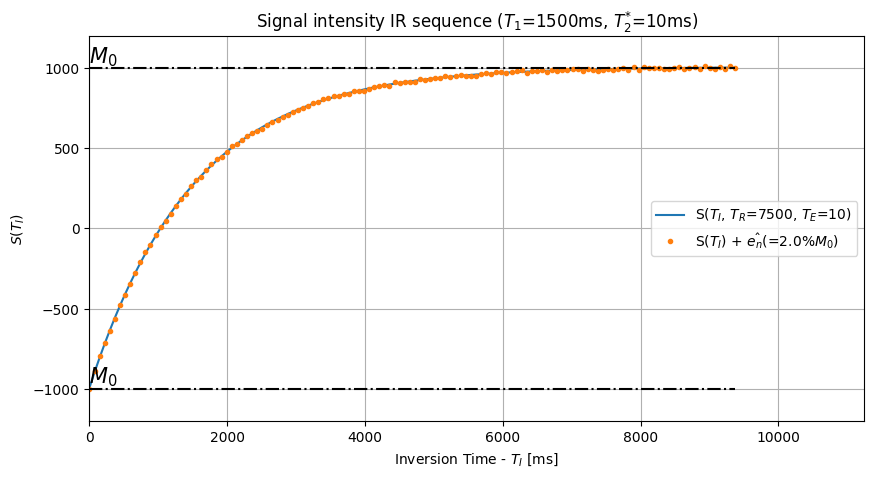

In [311]:
[TR, TE] = [5*T1, 10]
inversion_times = np.linspace(0.0, 1.25*TR, num=nt)
s_inversion = ir_signal(M0, T1, inversion_times, TR)
# Add white noise
noise_factor = 0.02
en_inv = noise_factor*M0*(np.random.rand(nt)-0.5)
s_inversion_noise = s_inversion + en_inv


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(inversion_times, s_inversion, label=r'S($T_I$, '+f'$T_R$={TR}, $T_E$={TE})')
ax.plot(inversion_times, s_inversion_noise, '.', label=r'S($T_I$) + $\hat{e_n}$'+f'(={noise_factor*100:.1f}%$M_0$)')
ax.plot(inversion_times, M0*np.ones_like(inversion_times), 'k-.')
ax.text(inversion_times[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.plot(inversion_times, -M0*np.ones_like(inversion_times), 'k-.')
ax.text(inversion_times[0], -M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(T_I)$')
ax.set_xlabel(r'Inversion Time - $T_I$ [ms]')
ax.set_title(f'Signal intensity IR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])
plt.show()


### Non-Linear Fit
Example fitting 3 parameters

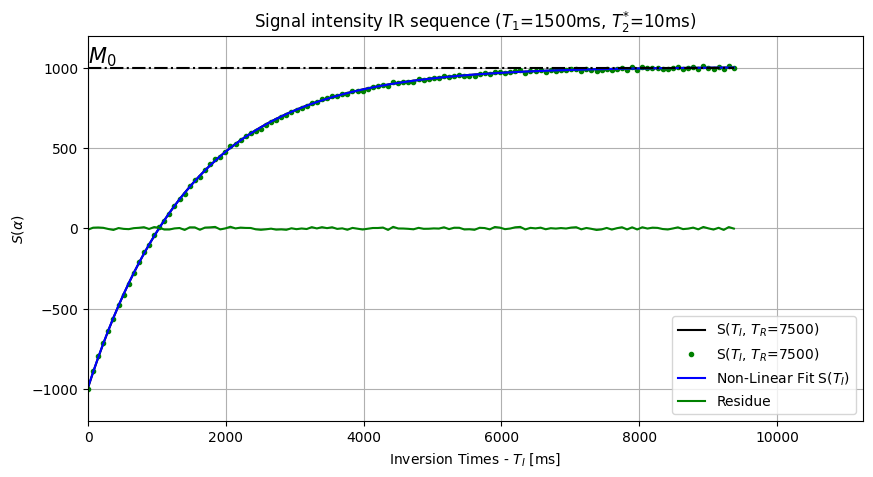

In [312]:
# Example non-linear fit    
t1_opt_ir = do_ir_fit(s_inversion_noise, inversion_times, TR)
non_lin_fit_ir_T1 = ir_signal(t1_opt_ir.params['s0'].value, 
                                  t1_opt_ir.params['t1'].value,
                                  inversion_times, TR, 
                                  f=t1_opt_ir.params['f'].value)
residual_ir_fit = s_inversion_noise - non_lin_fit_ir_T1

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10.0, 5.0))
ax.plot(inversion_times, s_inversion, 'k-', label=r'S($T_I$, '+f'$T_R$={TR})')
ax.plot(inversion_times, s_inversion_noise, 'g.', label=r'S($T_I$, '+f'$T_R$={TR})')
ax.plot(inversion_times, non_lin_fit_ir_T1, 'b-', label=r'Non-Linear Fit S($T_I$)')
ax.plot(inversion_times, residual_ir_fit, 'g-', label=r'Residue')
ax.plot(inversion_times, M0*np.ones_like(inversion_times), 'k-.')
ax.text(inversion_times[0], M0, r'$M_0$', va='bottom', ha='left', fontsize=15)
ax.set_ylabel(r'$S(\alpha)$')
ax.set_xlabel(r'Inversion Times - $T_I$ [ms]')
ax.set_title(f'Signal intensity IR sequence ($T_1$={T1}ms, '+r'$T_2^{*}$='+f'{T2star}ms)')
ax.legend(loc='best')
ax.grid(True)
ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])
plt.show()


## Reference Tissue Method for T1

(tbc) - Add Reference
Gradient Echo Sequence with the following conditions:
* Flip Angles > $30^{o}$ 
* $T_R << T_1$ (i.e. magnetisation if highly saturated)
Tissue assumptions
* Differences in $T_2^{*}$ between both tissues are relatively low
* Similar proton density between both tissues

These conditions ensures the main assumption is valid:
* The product $S\times T_1$ is approximately constant (get reference to justify this!)

and the central relationship is:
\begin{equation}
\frac{S}{S_{ref}} \approx \frac{T_{1ref}}{T_1}
\end{equation}


## Population AIF
In this section, an Arterial Input Function is defined by implementing the model proposed by [Parker et al. MRM 56(5): 993-1000; 2006](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21066), derived from the fitting of two gaussians distributions and an exponential function modulated with a sigmoid function to the mean AIF measurements of 67 AIFs (see details in the publication cited):

\begin{equation}
AIF_{Parker}(t) = \sum_{n=1}^{2} \frac{A_n}{\sigma_n\sqrt{2\pi}}e^{-\frac{(t - T_n)^{2}}{2\sigma_n^{2}}} + \alpha \frac{e^{-\beta t}}{1 + e^{-s(t-\tau)}}
\end{equation}

with the parameters defined in Table 1 of [Parker et al. MRM 56(5): 993-1000; 2006](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21066):

| Parameter |   $A_1$   |   $A_2$   |   $T_1$ | $T_2$  | $\sigma_1$ | $\sigma_2$ | $\alpha$ | $\beta$ |   s	   | $\tau$ |
| --------- | :----:    | :----:    | :----:  | :----: | :----:     | :----:     | :----:   | :----:  | :----: | :----: | 
| Value	    | 0.809	    | 0.330     | 0.17046 | 0.365  | 0.0563     | 0.132      | 1.050    | 0.1685  | 38.078 | 0.483  | 
| SD	    | 0.044	    | 0.040     | 0.00073 | 0.028  | 0.0011     | 0.021      | 0.017    | 0.0056  | 16.78  | 0.015  | 
| Units     | $\text{mmol} \cdot \text{min}$	| $\text{mmol} \cdot \text{min}$	| $\text{min}$	  | $\text{min}$	   | $\text{min}$	    | $\text{min}$        | $\text{mmol}$     | $\text{min}^{-1}$ | $\text{min}^{-1}$ | $\text{min}$    | 

More recently [Wang et al. MRI 34(2): 197-203; 2016](https://www.sciencedirect.com/science/article/abs/pii/S0730725X15002623) proposed the following functional form, with less parameters (8 instead of 10) and such that $C_p(t_{t=0}) = 0$:

\begin{equation}
AIF_{Wang}(t) = A \ln(1 + t) e^{-\beta t} (1 + \sum_{n=1}^{2} A_n e^{-\frac{(t-t_n)^{2}}{2\sigma_n^{2}}})
\end{equation}

with the parameters defined in Table 1 of [Wang et al. MRI 34(2): 197-203; 2016](https://www.sciencedirect.com/science/article/abs/pii/S0730725X15002623):

| Parameter |   $A$   |   $\beta$   |   $A_1$ | $\sigma_1$  | $t_1$   | $A_2$ | $\sigma_2$ | $t_2$  |   $R^{2}$ |
| --------- | :----:  | :----:     | :----:  |   :----:    | :----:  | :----:|  :----:    | :----: | :------: | 
| Value	    |  0.31 | 0.70 | 5.84 | 0.09 | 0.20 | 0.46 | 0.12 | 0.62 | 0.95 | 
| SD	    |  0.14 | 0.15 | 2.47 | 0.03 | 0.08 | 0.24 | 0.08 | 0.09 | 0.02 | 
| CV        |  0.44 | 0.22 | 0.42 | 0.38 | 0.40 | 0.52 | 0.65 | 0.15 | 0.02 |
| Units     | $\text{mmol}$	| $\text{min}^{-1}$	| []  | $\text{min}$ | $\text{min}$ | [] | $\text{min}$ | $\text{min}$ | [] | 



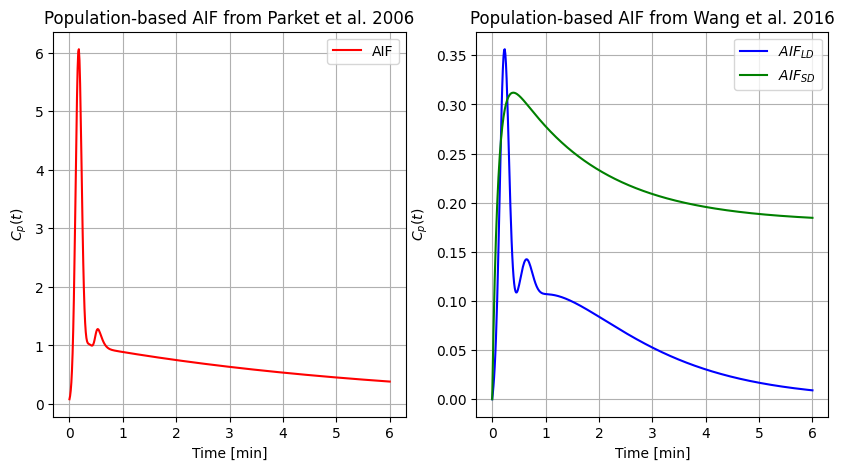

In [343]:
# Show population AIF:
tmax = 6.0 # min
time_axis = np.linspace(0.0, tmax, num=512) # min
aifParker = aif_parker(time_axis=time_axis)
aifWangLD = aif_wang(time_axis=time_axis, mode='LD')
aifWangSD = aif_wang(time_axis=time_axis, mode='SD')

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10.0, 5.0))
ax[0].plot(time_axis, aifParker, 'r-', label='AIF')
ax[0].set_ylabel(r'$C_p(t)$')
ax[0].set_xlabel('Time [min]')
ax[0].set_title(f'Population-based AIF from Parket et al. 2006')
ax[0].legend(loc='best')
ax[0].grid(True)
# ax.axis([0.0, 1.2*np.max(inversion_times), -1.2*M0, 1.2*M0])

ax[1].plot(time_axis, aifWangLD, 'b-', label=r'$AIF_{LD}$')
ax[1].plot(time_axis, aifWangSD, 'g-', label=r'$AIF_{SD}$')
ax[1].set_ylabel(r'$C_p(t)$')
ax[1].set_xlabel('Time [min]')
ax[1].set_title(f'Population-based AIF from Wang et al. 2016')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()

# for contrast_agent, r1 in relaxivities.items():
#     for tissue, t1value in tissues_T1.items():


## Contrast media concentrations
To simplify the analysis, I'll assume the tissue of interest and the contrast agent are in the fast-exchange regime (ref Yenkeelov et al.), so the relationships are direct and linear. Later on, I'll include sophistications and deviations from this situation. For now, in the fast-exchange regime, the relationship between the shortening of $T_1$ and the contrast agent is given by:
\begin{equation}
\frac{1}{T_1(c(t))} = \frac{1}{T_{10}} + r_1c(t)
\end{equation}
where $c(t)$ is the concentration of contrast agent, that varies over time (e.g. during washin/washout), $T_{10}$ the baseline $T_1$ of the tissue, i.e. the native $T_1$ that depends on the tissue and the main magnetic field, and $r_1$ the relaxivity of the contrast media, which is a constant for each agent and also depends on the main magnetic field (see Appendix 2 for relaxivity values of several contrast agents at 1.5T). $T_1(c(t))$ is the modified $T_1$ of the tissue, due to presence of the contrast agent. In the following figure, an example of different combinations of $T_{10}$, $c(t)$ and $r_1$ is shown over time.

To derive a concentration curve, is necessary to consider an AIF and a model to calculate forward the concentration...



In [328]:
# Relaxivities at 1.5T & 37C (see Appendix 2)
relaxivities = {'magnevist': 4.1,
                'multihance': 6.3,
                'omniscan': 4.3,
                'dotarem': 3.6,
                'prohance': 4.1, 
                'gadavist': 5.2,
                'eovist': 6.9,
                'vueway': 12.8 
                }
# Average T1 values of some tissues at 1.5T (see Appendix 2)
tissues_T1 = {
    'water'            :  4000,
    'csf'              : 4000, # same as water
    'gray matter'      : 900,
    'muscle'           : 900,
    'liver'            : 500,
    'fat'              : 250,
    'tendon'           : 400,
    'proteins'         : 250,
    'ice'              : 5000,
    'breast_fat'       : 334,
    'breast_glandular' : 1201
    }


In [ ]:
# Derive a concentration curve from the AIF using Tofts' Model:


# Appendices

## Linearisation of the SPGR equation
By considering $T_E << T_R$, $E_1(T_1, T_R)$ as just $E_1$, and repeating the acquisition for multiples flip angles $\alpha_i$ while keeping everything else constant, specially $T_R$ and $T_E$, the equation [] becomes:
\begin{equation}
S(\alpha_i) = S_i = M_0\sin\alpha_i\frac{1 - E_1}{1 - (\cos\alpha_i)E_1}
\end{equation}
multiplying by $(1 - (\cos\alpha_i)E_1)$:
\begin{equation}
S_i - S_i\cos\alpha_iE_1 = M_0\sin\alpha_i - M_0\sin\alpha_i E_1
\end{equation}
dividing by $\sin\alpha_i$ and reorganising the terms:
\begin{equation}
\frac{S_i}{\sin\alpha_i} - \frac{S_iE_1}{\tan\alpha_i} = M_0 - M_0E_1
\end{equation}
and isolating the signal intensity as a function of $E_1$, we get:
\begin{equation}
\frac{S_i}{\sin\alpha_i} = E_1\frac{S_i}{\tan\alpha_i} + M_0(1 - E_1)
\end{equation}


## Relaxitivy of contrast agents at 1.5T
The following table has been taken from https://s.mriquestions.com/what-is-relaxivity.html and is based on [Rohrer et al. Invest. Radiol 40:715-724; 2005](https://journals.lww.com/investigativeradiology/abstract/2005/11000/comparison_of_magnetic_properties_of_mri_contrast.5.aspx)

Relaxivitiy of plasma blood at $37^{o}$ and 1.5T:

| Brand Name  | $r_1\quad[L\ mmol^{-1} s^{-1}]$ |
| ------------|  :---------------------------:  |
| Magnevist®  | 4.1  |
| MultiHance® | 6.3  |
| Omniscan ™  | 4.3  |
| Dotarem®    | 3.6  |
| ProHance®   | 4.1  |
| Gadavist®   | 5.2  |
| Eovist®     | 6.9  |
| Vueway™     | 12.8 |


## $T_1$ of tissues at 1.5T
The following table has been taken from https://mri-q.com/why-is-t1--t2.html and for breast (fat and glandular tissues), I've used the average reported by [Rakow-Penner et al. JMRI 23(1): 87-91; 2005](https://onlinelibrary.wiley.com/doi/full/10.1002/jmri.20469)

Average $T_1$ values of some tissues at 1.5T

|    Tissue   | $T_1$[ms] | $T_2$[ms] |
| ----------- | :-------: | :-------: |
| Water/CSF   | 4000      | 2000      |
| Gray matter | 900       | 90        | 
| Muscle      | 900       | 50        | 
| Liver       | 500       | 40        | 
| Fat         | 250       | 70        | 
| Tendon      | 400       | 5         | 
| Proteins    | 250       | 0.1- 1.0  | 
| Ice         | 5000      | 0.001     | 
| Fat Tissue (Breast)  | 334       | 53        |
| Glandular Tissue (Breast)| 1201      | 58        |